In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import tensorflow as tf

import hmm

In [3]:
# hmm_tf = hmm.HMMTensorflow(np.array([0.0, 1.0]), np.array([[0.99, 0.01], [0.01, 0.99]]))
P = np.array([[0.9, 0.1], [0.1, 0.9]])
P = P**1
P = P / np.sum(P,1)
# P = np.array([[0.5, 0.5], [0.01, 0.99]])
# P = np.array([[0.5, 0.5], [0.0, 1.0]])
print 'P', P
hmm_tf = hmm.HMMTensorflow(np.array([0.0, 1.0]), P)

P [[ 0.9  0.1]
 [ 0.1  0.9]]


In [4]:
# observations = np.array([0, 0.0, 1.0, 1.0])
# observations = np.array([0.5] * 60)
# observations = np.random.random(60)
observations = np.zeros(90)
observations = np.sin(np.arange(-10, 10, 20/90.))
# observations -= 0.2
# observations[62:] = 0.2
# observations += np.arange(-1, 1, 2 / 90.)
# observations += np.random.random(90) * 0.4 - 0.2

In [5]:
truth = np.array([[1, 0]]*60 + [[0, 1]]*30, dtype=float)

In [6]:
observation_variables = [tf.Variable(e) for e in np.array(observations, dtype=np.float64)]

In [7]:
posterior_graph, _, _ = hmm_tf.forward_backward([tf.sigmoid(o) for o in observation_variables])

In [8]:
# build error function
sum_error_squared = sum([
    tf.square(t - p) for t, p in zip(truth, posterior_graph)
])

In [9]:
# calculate d_observation/d_error
gradients_graph = tf.gradients(sum_error_squared, observation_variables)

In [10]:
session = tf.Session()
session.run(tf.initialize_all_variables())

In [11]:
steps = 0

In [133]:
posterior = np.concatenate(session.run(posterior_graph))

sum error squared: 0.595


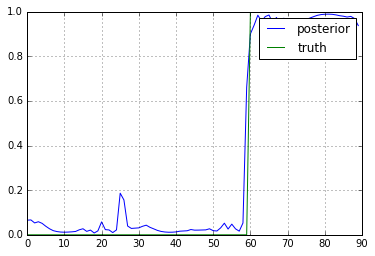

In [134]:
print 'sum error squared: %.03f' % sum((truth[:,1] - posterior[:,1])**2)
plot(posterior[:,1], label='posterior')
plot(truth[:,1], label='truth')
grid()
legend()

In [135]:
gradients = session.run(gradients_graph)

In [136]:
# whiten gradients
gradients = gradients / np.std(gradients)

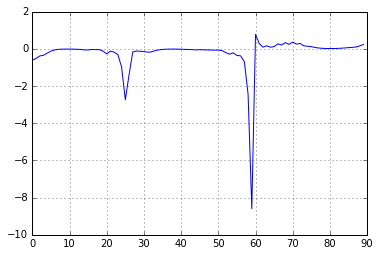

In [137]:
plot([-g for g in gradients])
grid()

In [138]:
# gradient descent step
steps += 1
observations = session.run([
    v.assign_sub(g * 0.5 * (random.random() - 0.25))
    for v, g in zip(observation_variables, gradients)
])

In [139]:
"""
observations = session.run([
    v.assign_add(random.random() * 2 - 1)
    for v in observation_variables
])
"""

'\nobservations = session.run([\n    v.assign_add(random.random() * 2 - 1)\n    for v in observation_variables\n])\n'

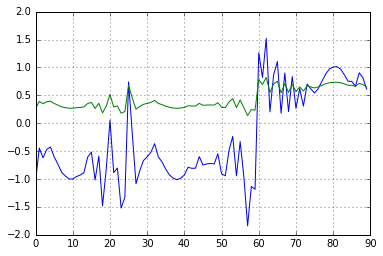

In [140]:
plot(observations)
sigmoid = np.vectorize(lambda(x): 1.0/(1.0+np.exp(-x)))
plot(sigmoid(observations))
grid()

In [141]:
hmm_np = hmm.HMMNumpy(np.array([0.0, 1.0]), np.array([[0.9, 0.1], [0.1, 0.9]]))
# hmm_np = hmm.HMMNumpy(np.array([0.0, 1.0]), P)

In [142]:
out, _ = hmm_np.viterbi_decode(sigmoid(observations))

step: 12
viterbi error: 0.0


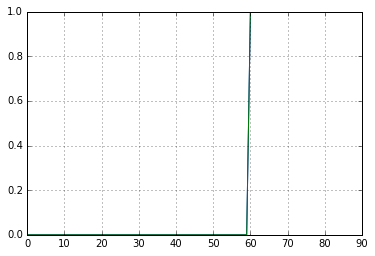

In [143]:
print 'step:', steps
print 'viterbi error:', sum((truth[:,1] - out)**2)
plot(truth[:,1])
plot(out)
grid()